In [2]:
import pandas as pd 
import numpy as np

In [3]:
ratings = pd.read_csv("ratings.csv")
links = pd.read_csv("links.csv")
movies = pd.read_csv("movies.csv")
tags = pd.read_csv("tags.csv")

In [4]:
print("Ratings:", ratings.shape)
print("Movies:", movies.shape)
print("Tags:", tags.shape)
print("Links:", links.shape)

Ratings: (32000204, 4)
Movies: (87585, 3)
Tags: (2000072, 4)
Links: (87585, 3)


In [5]:
# Random sampling of 10k
sample_users = ratings['userId'].drop_duplicates().sample(10000, random_state=42)
sample_ratings = ratings[ratings['userId'].isin(sample_users)]
print("Sampled users Shape:", sample_users.shape)
print("Sampled Ratings Shape:", sample_ratings.shape)

Sampled users Shape: (10000,)
Sampled Ratings Shape: (1588747, 4)


In [6]:
# Merge the datasets
sample_data = sample_ratings.merge(movies, on='movieId', how='left')
sample_data = sample_data.merge(links, on='movieId', how='left')

In [7]:
sample_data.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'imdbId',
       'tmdbId'],
      dtype='object')

In [8]:
## URL generation of imdb and tmdb
sample_data['imdb_url'] = "https://www.imdb.com/title/tt" + sample_data['imdbId'].astype(str).str.zfill(7)
sample_data['tmdb_url'] = "https://www.themoviedb.org/movie/" + sample_data['tmdbId'].astype('Int64').astype(str)

In [9]:
sample_data.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,imdb_url,tmdb_url
0,5,10,4.0,840768638,GoldenEye (1995),Action|Adventure|Thriller,113189,710.0,https://www.imdb.com/title/tt0113189,https://www.themoviedb.org/movie/710
1,5,47,3.0,840768897,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,114369,807.0,https://www.imdb.com/title/tt0114369,https://www.themoviedb.org/movie/807
2,5,110,4.0,840768763,Braveheart (1995),Action|Drama|War,112573,197.0,https://www.imdb.com/title/tt0112573,https://www.themoviedb.org/movie/197
3,5,150,3.0,840763914,Apollo 13 (1995),Adventure|Drama|IMAX,112384,568.0,https://www.imdb.com/title/tt0112384,https://www.themoviedb.org/movie/568
4,5,153,3.0,840764018,Batman Forever (1995),Action|Adventure|Comedy|Crime,112462,414.0,https://www.imdb.com/title/tt0112462,https://www.themoviedb.org/movie/414


In [10]:
user_movie_matrix = sample_data.pivot_table(
    index='userId',
    columns='title',
    values='rating'
)

In [11]:
## Filling ratings 0
user_movie_matrix_filled = user_movie_matrix.fillna(0)
print("User-Movie matrix shape: ", user_movie_matrix_filled.shape)

User-Movie matrix shape:  (10000, 31854)


In [12]:
user_movie_matrix_filled.head()

title,(2019),"""Great Performances"" Cats (1998)","""Sr."" (2022)",#1 Cheerleader Camp (2010),#Alive (2020),#AnneFrank. Parallel Stories (2019),#Female Pleasure (2018),#Horror (2015),#Iamhere (2020),#SCREAMERS (2016),...,Никто не знает про секс (2006),Обезьянки и грабители (1985),Он вам не Димон (2017),Пес Барбос и необычный кросс (1961),Приключения Домовёнка (1986),Принцесса и Людоед (1977),Сердца трех (1992),Собака Павлова (2005),Юленька (2009),Я худею (2018)
userId,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

# Convert dense DataFrame to sparse matrix
sparse_matrix = csr_matrix(user_movie_matrix_filled.values)

# Apply TruncatedSVD on sparse matrix
svd = TruncatedSVD(n_components=100, random_state=42)
user_features = svd.fit_transform(sparse_matrix)

print("Reduced shape:", user_features.shape)


Reduced shape: (10000, 100)


In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42, n_init= 'auto')
user_clusters = kmeans.fit_predict(user_features)

In [15]:
user_cluster_df = pd.DataFrame({
    'userId': user_movie_matrix_filled.index,
    'cluster': user_clusters
})

user_cluster_df.head()


,userId,cluster
0,5,1
1,7,1
2,13,3
3,34,0
4,71,1


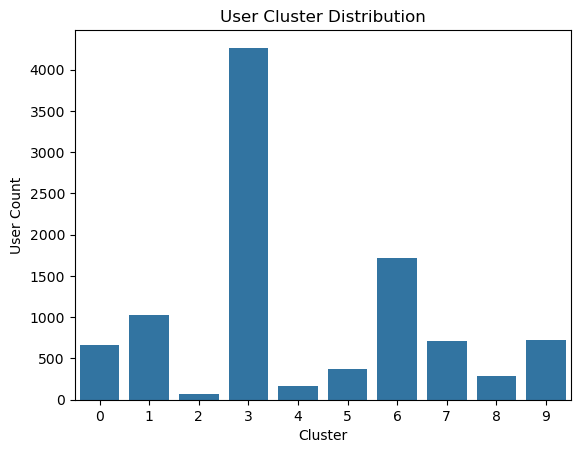

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='cluster', data=user_cluster_df)
plt.title("User Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("User Count")
plt.show()

In [17]:
## Cluster Inspection
cluster_0_users = user_cluster_df[user_cluster_df['cluster'] == 0]['userId']

cluster_0_ratings = sample_data[sample_data['userId'].isin(cluster_0_users)]

top_movies = (
    cluster_0_ratings
    .groupby('title')['rating']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

print(top_movies)

title
À nous la liberté (Freedom for Us) (1931)                  5.0
Gang Related (1997)                                        5.0
Larry David: Curb Your Enthusiasm (1999)                   5.0
BlacKkKlansman (2018)                                      5.0
Free Solo (2018)                                           5.0
Strawberry and Chocolate (Fresa y chocolate) (1993)        5.0
Bon Voyage, Charlie Brown (and Don't Come Back!) (1980)    5.0
Flawless (1999)                                            5.0
Swiss Army Man (2016)                                      5.0
Cherish (2002)                                             5.0
Name: rating, dtype: float64


In [18]:
sample_with_clusters = sample_data.merge(user_cluster_df, on='userId', how='left')

In [19]:
## Group by Clusters
cluster_movie_stats = (
    sample_with_clusters
    .groupby(['cluster', 'title'])
    .agg(avg_rating=('rating', 'mean'), rating_count=('rating', 'count'))
    .reset_index()
)

popular_movies_per_cluster = cluster_movie_stats[cluster_movie_stats['rating_count'] >= 30]

top_movies_by_cluster = (
    popular_movies_per_cluster
    .sort_values(['cluster', 'avg_rating'], ascending=[True, False])
)

In [20]:
def recommend_movies(cluster_id, n=10):
    return (
        top_movies_by_cluster[top_movies_by_cluster['cluster'] == cluster_id]
        .head(n)
        [['title', 'avg_rating', 'rating_count']]
        .reset_index(drop=True)
    )

recommend_movies(5)

,title,avg_rating,rating_count
0,Planet Earth II (2016),4.666667,30
1,Planet Earth (2006),4.509804,51
2,Whiplash (2013),4.450980,51
3,Fight Club (1999),4.443056,360
4,Pulp Fiction (1994),4.442416,356
5,Band of Brothers (2001),4.427083,48
6,"Shawshank Redemption, The (1994)",4.375000,344
7,"Godfather: Part II, The (1974)",4.329832,238
8,"Godfather, The (1972)",4.329470,302
9,12 Angry Men (1957),4.300000,155


In [21]:
movie_genres = sample_data[['movieId', 'title', 'genres']].drop_duplicates()

movie_genres['genres'] = movie_genres['genres'].str.split('|')
movie_genres_exploded = movie_genres.explode('genres')

# Create one-hot encoded genre columns
movie_genre_ohe = pd.get_dummies(movie_genres_exploded, columns=['genres'])

# Collapse back to one row per movie (by summing genre one-hots)
movie_genre_features = (
    movie_genre_ohe
    .groupby(['movieId', 'title'])
    .sum()
    .reset_index()
)

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar_movies(title, top_n=10):
    # Extract just the genre vector matrix
    genre_vectors = movie_genre_features.drop(['movieId', 'title'], axis=1)

    # Find index of the input movie
    try:
        idx = movie_genre_features[movie_genre_features['title'] == title].index[0]
    except IndexError:
        return f" Movie '{title}' not found in dataset."

    # Compute cosine similarity between the selected movie and all others
    similarities = cosine_similarity([genre_vectors.iloc[idx]], genre_vectors)[0]

    # Get top N most similar (excluding the movie itself)
    similar_indices = similarities.argsort()[::-1][1:top_n + 1]

    # Return titles of similar movies
    similar_movies = movie_genre_features.iloc[similar_indices][['title']]
    similar_movies['similarity'] = similarities[similar_indices]

    return similar_movies.reset_index(drop=True)



In [23]:
recommend_similar_movies("Titanic (1997)")

,title,similarity
0,Phantom Thread (2017),1.0
1,"Europeans, The (1979)",1.0
2,Two Women (2014),1.0
3,Tulip Fever (2017),1.0
4,None But the Lonely Heart (1944),1.0
5,Farewell Meu Amor (2016),1.0
6,Parallel Sons (1995),1.0
7,Emma's Bliss (Emmas Glück) (2006),1.0
8,"Heiress, The (1949)",1.0
9,Moment by Moment (1978),1.0


In [25]:
movie_genre_features.to_pickle("../model/movie_genre_features.pkl")